[![Amazon Logo](images/amazon-reviews.gif)](images/amazon-reviews.gif)

# Overview:

The following model will use one of the datasets found from [http://jmcauley.ucsd.edu/data/amazon/](http://jmcauley.ucsd.edu/data/amazon/) to perform sentiment analysis on the given Amazon reviews. The **electronic dataset** has been selected for this example to create a model that algorithmically predict if a review is positive or negative just based on its text. The model shown below will utilize natural language processing to predict the sentiment of a given text.

### Import libaries:

In [1]:
import pandas as pd
import gzip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from wordcloud import WordCloud

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Create helper function:

The helper function below will assist in converting JSON to Pandas.

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

The original file format of the Amazon review files is in JSON. The converted JSON file will be renamed as **"df"** once it's converted to a Pandas dataframe. As shown below, when viewing the summarized information it appears that the column **"reviewerName"** is the only one to contain **NaN (not a number) value(s)**.

In [3]:
df = getDF('reviews_Electronics_5.json.gz')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
reviewerID        1689188 non-null object
asin              1689188 non-null object
reviewerName      1664458 non-null object
helpful           1689188 non-null object
reviewText        1689188 non-null object
overall           1689188 non-null float64
summary           1689188 non-null object
unixReviewTime    1689188 non-null int64
reviewTime        1689188 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 128.9+ MB


### Viewing the general information:

When viewing the general information there are a few things that can be observed.
1. The columns **"reviewText" & "summary"** appears to be the sentiments that are going to be analyzed.
2. There aren't any column to determine if the review is positive or negative. We will have to use the column **"overall"** as a road map. (This will be explained further below)

(**Note**: for future analysis we can determined if a certain repeat customer are repeat positive reviewer or negative reviewer or if their reviews are helpful to other potential customers. A reward program can be implemented to the most helpful reviewer to establish loyalty and to attract more customers.

In [4]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


### Common Reviewers:

After taking a look at the common reviewers by the **"reviewerName"** column, it appears there aren't any information that can be derived from this column. This is due to **"Amazon Customer** and other common names appears to be the individuals that are leaving these reviews. It would be hard to believe that there is **one individual** named **Mike** that reviewed 2,340 electronic items. It would be safer to assume that there were many individuals named **Mike** that were leaving a review.

When looking at the column **"reviewerID"**, this provides more information that can be digested or will prove to be useful. As there are many reviewer ID's that are in the hundreds which means that these reviewers are leaving multiple reviews. It would be prudent to dig deeper to see the mean of the helpfulness of the reviews that these individuals are leaving or even the percentage mean of the people that feel that their reviews are helpful. That would be a better indicator whether that particular individual is leaving helpful or unhelpful reviews. This **"reviewer rewards program"** project will be tabled for another time, as the purpose of the model we are trying to satisfy is to determine whether a review is positive or negative.

In [5]:
df.reviewerName.value_counts().head(10)

Amazon Customer    26961
Mike                2340
Chris               2127
John                2116
David               1679
Michael             1604
Mark                1576
Steve               1504
Dave                1486
Scott               1271
Name: reviewerName, dtype: int64

In [6]:
df.reviewerID.value_counts().head(10)

ADLVFFE4VBT8      431
A3OXHLG6DIBRW8    407
A6FIAB28IS79      367
A680RUE1FDO8B     352
A5JLAU2ARJ0BO     351
A1ODOGXEYECQQ8    333
A36K2N527TXXJN    281
ARBKYIVNYWK3C     267
A25C2M3QF9G7OQ    261
AWPODHOB4GFWL     260
Name: reviewerID, dtype: int64

### Ratings:

Let's determine the ratings by breaking it down to the type of ratings the data contains and distribution of the type of those ratings. Doing so will determine what will be considered to be positive or negative and whether we will have an imbalanced dataset.

In [7]:
print('Ratings', df.overall.unique())

Ratings [ 5.  1.  3.  2.  4.]


In [8]:
ratings = df.overall.value_counts()
ratings = ratings.reset_index()
ratings.columns = ['ratings', 'freq']
ratings['per%'] = ratings['freq'] / ratings['freq'].sum()
ratings

,ratings,freq,per%
0,5.0,1009026,0.597344
1,4.0,347041,0.205448
2,3.0,142257,0.084216
3,1.0,108725,0.064365
4,2.0,82139,0.048626


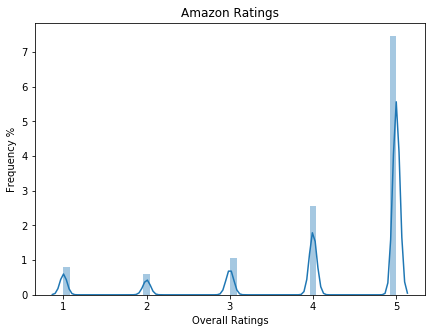

In [9]:
f, ax = plt.subplots(figsize=(7, 5))

sns.distplot(df.overall)
plt.title('Amazon Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency %')
plt.show()

Although the following decision will leave the dataset imbalanced, to satisfy the purpose of the model the model needs to define what is positive and what is negative. Let's define a positive review as a **4 rating and above** while **3 rating and below** will be considered as negative. The assumption behind separating it into these 2 particular categories is that although 3 is a neutral score, it would be best to include this as part of the negative as an attempt to balance the dataset however little it may actually impact the overall model.

In [10]:
df['sentiment'] = np.where(df['overall'] == 5.0, 1,
                           np.where(df['overall'] == 4.0, 1, 0))
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013",1
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010",0
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010",0
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010",0
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011",0


### Positive/Negative Ratio:

As shown **below** the dataset is now 80/20, in favor of positive reviews. It's best to take into account that an accuracy score in the area of 80% would not be significant as the set is imbalanced. It is essential to include the precision and recall scores for this dataset.

**0 =** Negative Sentiment<br/>
**1 =** Positive Sentiment

In [11]:
bal = df.groupby('sentiment').size()
bal = bal.reset_index()
bal.columns = ['sentiment', 'freq']
bal['per%'] = bal.freq / bal.freq.sum()
bal

,sentiment,freq,per%
0,0,333121,0.197208
1,1,1356067,0.802792


### Stop Words and Vectors:

**Stop Words** - In computing, stop words are words which are filtered out before or after processing of natural language data (text). Though "stop words" usually refers to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list. Some tools specifically avoid removing these stop words to support phrase search.

Any group of words can be chosen as the stop words for a given purpose. For some search engines, these are some of the most common, short function words, such as the, is, at, which, and on. In this case, stop words can cause problems when searching for phrases that include them, particularly in names such as "The Who", "The The", or "Take That". Other search engines remove some of the most common words—including lexical words, such as "want"—from a query in order to improve performance. ~ [(WikiPedia)](https://en.wikipedia.org/wiki/Stop_words)

**TFID Vectorizer** - In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Nowadays, tf-idf is one of the most popular term-weighting schemes; 83% of text-based recommender systems in the domain of digital libraries use tf-idf.

Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. ~ [(WikiPedia)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [14]:
stopset = set(stopwords.words('english'))
tvec = TfidfVectorizer(use_idf=True,
                       strip_accents='ascii',
                       stop_words=stopset)

### Full Length Review:

To determine the sentiment, let's take a look at the full length review **first** and determine which words will hold the most weight.

In [15]:
Y = df.sentiment
X = tvec.fit_transform(df.reviewText)

print(Y.shape)
print(X.shape)

(1689188,)
(1689188, 515358)


In [16]:
weights = np.asarray(X.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
226485,great,0.025745
330992,one,0.022430
224021,good,0.021674
481129,use,0.020581
504623,works,0.020346
496865,well,0.018173
281283,like,0.017422
505238,would,0.017121
362367,price,0.016315
125858,case,0.016015


### Split Training & Test Data:

To observe and have confidence that the model is performing well, it is essential to split the dataset to training set and a testing set. Once the model is trained on the training set we will test it against the testing set. Doing so will enable us to see if the trained model is overfitting or it can handle unseen datasets.

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

nbm = naive_bayes.MultinomialNB()
nbm.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Scoring for Full Length Review:

It appears that the area under the curve score is only .84 (rounded). This is not a good score as our imbalanced dataset is already at 80/20 ratio. Let's move on and see if the summary column will have words that will assist in better scoring.

In [18]:
roc_auc_score(Y_test, nbm.predict_proba(X_test)[:,1])

0.84038544231948775

### Summarized Review:

The column summary contains the summarized form of the full review. This might give stronger words that will identify whether a summarized review is positive or negative. In other words, the summarized version might have stronger polarized words.

In [19]:
Y2 = df.sentiment
X2 = tvec.fit_transform(df.summary)

print(Y2.shape)
print(X2.shape)

(1689188,)
(1689188, 76355)


In [20]:
weights = np.asarray(X2.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
32525,great,0.063957
74432,works,0.041520
32078,good,0.039279
53446,product,0.021609
53140,price,0.020477
47055,nice,0.017673
27130,excellent,0.015573
50741,perfect,0.015017
41778,love,0.013833
16186,case,0.012480


In [21]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2)

nbm2 = naive_bayes.MultinomialNB()
nbm2.fit(X2_train, Y2_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Scoring for Summarized Review:

The score shown below is better than the **"Full Length Review"** score. Although it might be sligthly better, the score is not at an acceptable level.

In [22]:
roc_auc_score(Y2_test, nbm2.predict_proba(X2_test)[:,1])

0.87057916207072827

### When you hit a wall it's...

[![new](images/try-something-new.jpg)](images/try-something-new.jpg)

# A Different Approach:

A different approach is now required as the scores above are not at an acceptable level. The dataset below is rebalanced to have a 50/50 ratio. Due to the overall (sample) size of the data set. It would be acceptable to decrease the number of positive reviews to match the number of negative reviews.

(**Note**: An imbalanced dataset can skew the perception of an acceptable level of accuracy score.)

In [23]:
df_copy = df.drop(df.query('sentiment == 1').sample(frac=.7543476834, random_state = 5).index)

bal = df_copy.groupby('sentiment').size()
bal = bal.reset_index()
bal.columns = ['sentiment', 'freq']
bal['per%'] = bal.freq / bal.freq.sum()
bal

,sentiment,freq,per%
0,0,333121,0.5
1,1,333121,0.5


### A Picture is Worth a Thousand Words:

It's not exactly 1,000 words below, however it helps to view which are the positive or negative words and even words that are both positive and negative.

**White Background =** Positive Words <br/>
**Black Background =** Negative Words

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


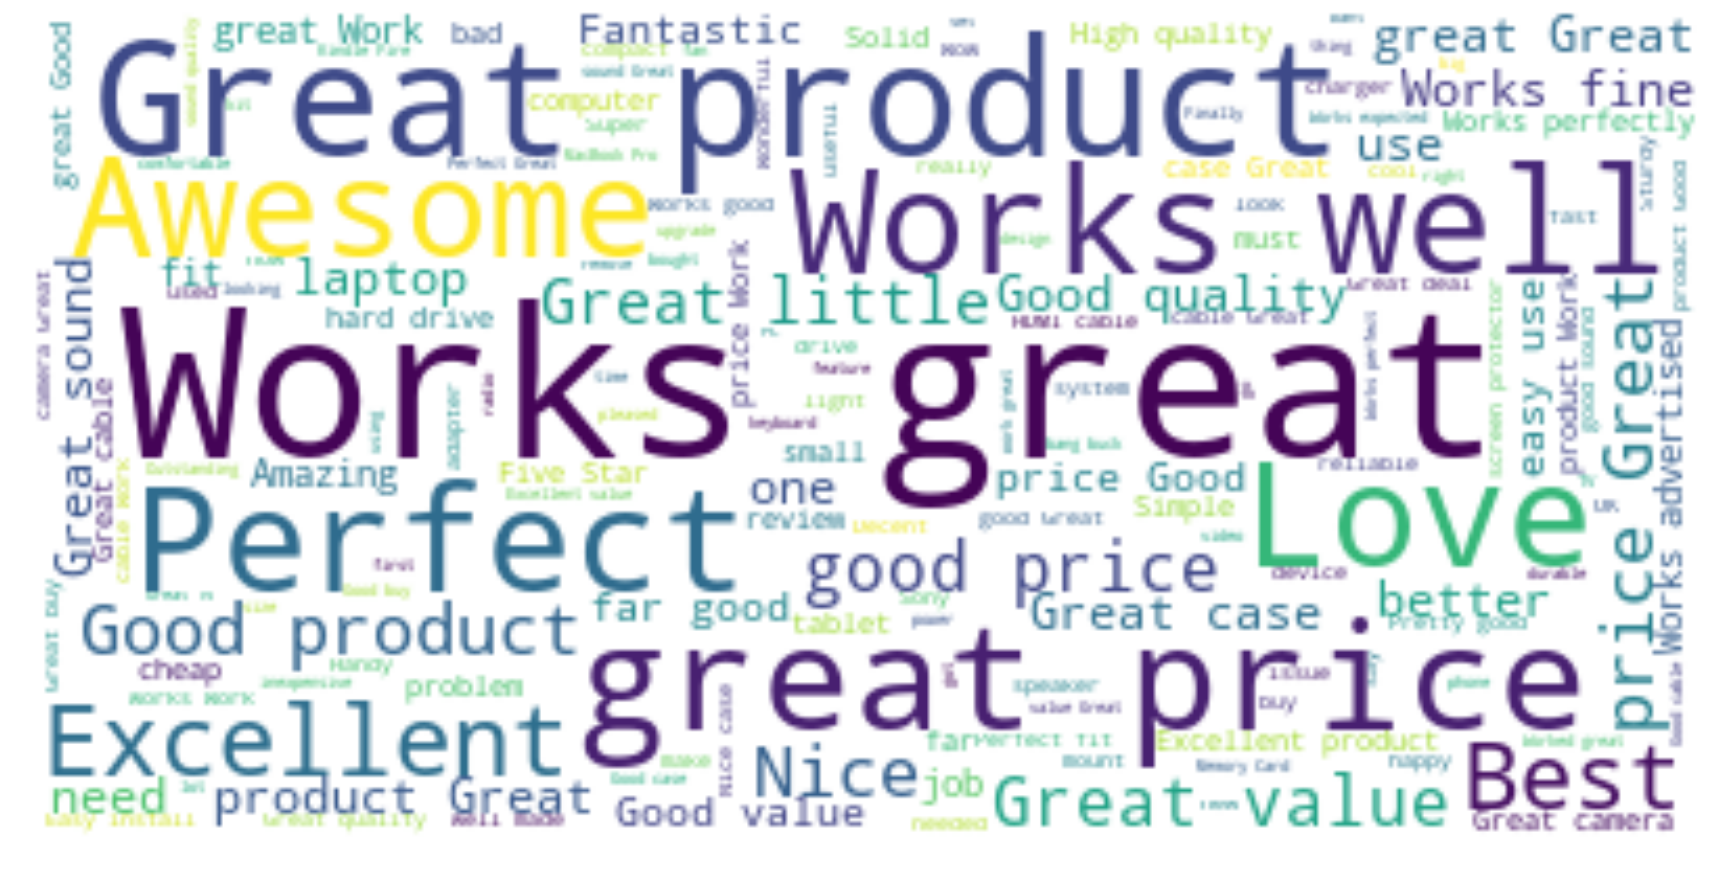

In [24]:
df_p = df_copy[df['sentiment'] == 1]
df_p = df_p.reset_index()
df_n = df_copy[df['sentiment'] == 0]
df_n = df_n.reset_index()

wordcloud = WordCloud(background_color="white",
                      max_font_size=50).generate(' '.join(df_p['summary']))
plt.figure(figsize=(30, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

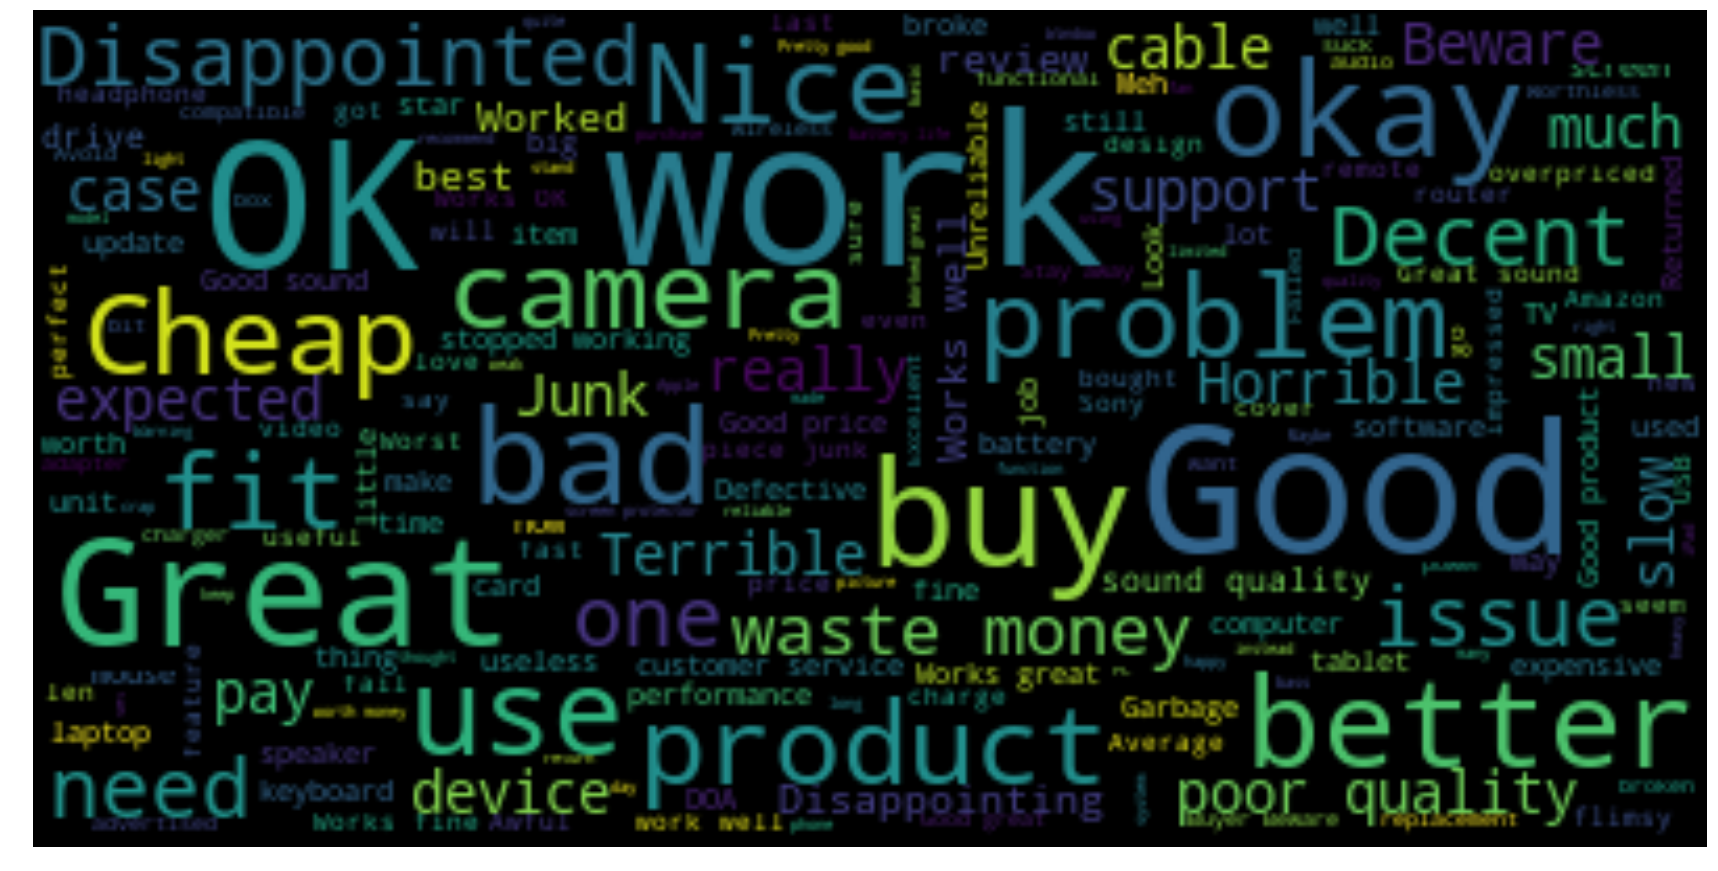

In [25]:
wordcloud = WordCloud(background_color="black",
                      max_font_size=50).generate(' '.join(df_n['summary']))
plt.figure(figsize=(30, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Taking another stab at Full Length Reviews:

With the rebalanced dataset, let's see how the model fares on the full length review. Please also note that the shape has been reduced due to the reduced dataset.

In [26]:
Y = df_copy.sentiment
X = tvec.fit_transform(df_copy.reviewText)

print(Y.shape)
print(X.shape)

(666242,)
(666242, 298506)


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

nbm = naive_bayes.MultinomialNB()
nbm.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Scoring Full Length Review - Take 2:

Although the score below appears the same due scoring similarly on a different ratio:

**Original:** 80/20<br/>
**Modified:** 50/50

In [28]:
roc_auc_score(Y_test, nbm.predict_proba(X_test)[:,1])

0.87212223017018575

### Taking another stab at the Summarized Reviews:

With the rebalanced dataset, let's see how the model fares on the summarized form of the reviews. Please also note that the shape has been reduced due to the reduced dataset.

In [29]:
Y2 = df_copy.sentiment
X2 = tvec.fit_transform(df_copy.summary)

print(Y2.shape)
print(X2.shape)

(666242,)
(666242, 48563)


In [30]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2)

nbm2 = naive_bayes.MultinomialNB()
nbm2.fit(X2_train, Y2_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Scoring Summarized Review - Take 2:

It scored similarly to the full lenght version. It is safe to assume that the model fares better when classes are balanced.

In [31]:
roc_auc_score(Y2_test, nbm2.predict_proba(X2_test)[:,1])

0.87366172646065443

# Confusion Matrix

Predicted      0      1     All
Actual                         
0          62668  20636   83304
1          14551  68706   83257
All        77219  89342  166561


Accuracy: 0.79
Precision: 0.77
Recall: 0.83
F1 Score: 0.80


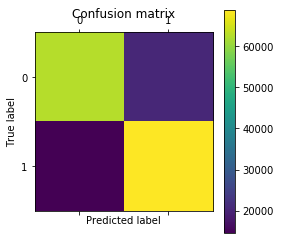

Accuracy: 
 [ 0.78444581  0.78641931  0.79524496  0.78858069  0.79025576  0.79430836
  0.79011167  0.78935519  0.78834654  0.79292147  0.7871938   0.78685159]
Mean Accuracy:  0.789502928537 Std Accuracy:  0.00314034569894 

Precision: 
 [ 0.77224616  0.77285518  0.77921237  0.77294719  0.77305229  0.77711824
  0.77115249  0.77270412  0.76553326  0.77276844  0.76468245  0.77138573]
Mean Precision:  0.772138160184 Std Precision:  0.00385496795677 

Recall: 
 [ 0.80685134  0.81127522  0.82395533  0.81721902  0.82175793  0.82532421
  0.82507205  0.81988473  0.83130403  0.82986311  0.82971902  0.81534582]
Mean Recall:  0.821464316609 Std Recall:  0.00733153190035 



In [34]:
Y2_pred = nbm2.predict(X2_test)

df_confusion = pd.crosstab(Y2_test, Y2_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
FP = df_confusion.loc[df_confusion.index == False, True].iloc[0]
TN = df_confusion.loc[df_confusion.index == False, False].iloc[0]
TP = df_confusion.loc[df_confusion.index == True, True].iloc[0]
FN = df_confusion.loc[df_confusion.index == True, False].iloc[0]

print(df_confusion)

print('\n')
KTTS_Accuracy = (TN+TP)/(FP+TN+TP+FN)
print('Accuracy: {:,.2f}'.format(KTTS_Accuracy))

KTTS_Precision = TP/(TP+FP)
print('Precision: {:,.2f}'.format(KTTS_Precision))

KTTS_Recall = TP/(TP+FN)
print('Recall: {:,.2f}'.format(KTTS_Recall))

KTTS_F1 = 2*(KTTS_Recall * KTTS_Precision) / (KTTS_Recall + KTTS_Precision)
print('F1 Score: {:,.2f}'.format(KTTS_F1))

cm = confusion_matrix(Y2_test, Y2_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

acc = cross_val_score(nbm2, X2, Y2, cv=12, scoring='accuracy')
pre = cross_val_score(nbm2, X2, Y2, cv=12, scoring='precision')
rec = cross_val_score(nbm2, X2, Y2, cv=12, scoring='recall')

print('Accuracy:', '\n', acc)
print('Mean Accuracy: ', acc.mean(), 'Std Accuracy: ', acc.std(), '\n')
print('Precision:', '\n', pre)
print('Mean Precision: ', pre.mean(), 'Std Precision: ', pre.std(), '\n')
print('Recall:', '\n', rec)
print('Mean Recall: ', rec.mean(), 'Std Recall: ', rec.std(), '\n')

### Cross Valdation:

To ensure that the model is performing, it is crucial to cross validate. The above cross validation demonstrates that the model is stable and accurate as the standard deviation between the scores are fairly low.

# Final Test

The example below demonstrates how the model will predict a made up review as a positive or negative review:

**Note:<br/>
Negative** = 0<br/>
**Positive** = 1

In [36]:
test_review_array = np.array(['The new iphone x is good and worth the upgrade, buy it!'])
test_review_vector = tvec.transform(test_review_array)
print(nbm2.predict(test_review_vector))

[1]


In [37]:
test_review_array2 = np.array(["The new iphone x is not good and always breaks down, don't buy!"])

test_review_vector2 = tvec.transform(test_review_array2)
print(nbm2.predict(test_review_vector2))

[0]


### Summary:
Shown above, the model predicted the correct sentiments for the reviews.